# Text Classification and Analysis
Now we're at the point where we should be able to:
* Read in a collection of documents - a *corpus* which contains the seen1 papers (manually labelled)
* Transform text into numerical vector data using a pipeline
* Try different models for different pipelines
* Use k-fold to text model improvement
* Create a classifier
* Fit/train the classifier
* Evaluate performance
* Test the classifier on new data
* Select the best performing model
* Label unseen data using the best performing model
* Create a file with only relevant papers
* Start analysis using various NLP techniques including topic modeling, geoparsing and sentiment analysis

## Perform imports and load the dataset
The seen dataset contains the bibliometric information of over 1600 publications which have been manually labelled by two authors. Inconsistencies have been discussed and agreed upon. 

In [1]:
from typing import Tuple
import copy as cp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
### TODO Add your file path ###
file_path = '../Data/'
#File that was extracted from the big database having only labelled data. Relevant = 1 means relevant.
file_name = 'seen1.xlsx'
df = pd.read_excel(file_path + file_name)

df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../Data/seen1.xlsx'

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DOI             1636 non-null   object 
 1   Title           1636 non-null   object 
 2   Abstract        1636 non-null   object 
 3   Source title    1518 non-null   object 
 4   PubYear         1636 non-null   int64  
 5   Authors         1622 non-null   object 
 6   Times cited     1636 non-null   int64  
 7   processed_text  1636 non-null   object 
 8   topic_0         1636 non-null   float64
 9   topic_1         1636 non-null   float64
 10  topic_2         1636 non-null   float64
 11  topic_3         1636 non-null   float64
 12  topic_4         1636 non-null   float64
 13  Topic           1636 non-null   int64  
 14  Topic Label     1636 non-null   object 
 15  Relevant        1636 non-null   int64  
 16  Sustainability  822 non-null    float64
 17  Agro            826 non-null    f

In [4]:
len(df)

1636

### Take a look at a typical abstract.

In [4]:
from IPython.display import Markdown, display
display(Markdown('> '+df['Abstract'][100]))

> The American Thoracic Society (ATS), in collaboration with George Mason University, surveyed international members of the society to assess perceptions, clinical experiences, and preferred policy responses related to global climate change. A recruitment email was sent by the ATS President in October 2015 to 5,013 international members. Subsequently, four reminder emails were sent to nonrespondents. Responses were received from 489 members in 68 countries; the response rate was 9.8%. Half of respondents reported working in countries in Asia (25%) or Europe (25%), with the remainder in South America (18%), North America (Canada and Mexico) (18%), Australia or New Zealand (9%), and Africa (6%). Survey estimate confidence intervals were ± 5% or smaller. A high percentage of international ATS survey respondents judged that climate change is happening (96%), that it is driven by human activity (70%), and that it is relevant to patient care ("a great deal"/"a moderate amount") (80%). A majority of respondents also indicated they are already observing health impacts of climate change among their patients; most commonly as increases in chronic disease severity from air pollution (88%), allergic symptoms from exposure to plants or mold (72%), and severe weather injuries (69%). An even larger majority anticipated seeing these climate-related health impacts in the next two decades. Respondents further indicated that physicians and physician organizations should play an active role in educating patients, the public, and policy makers on the human health effects of climate change. International ATS respondents, like their counterparts in the U.S., observed that human health is already adversely affected by climate change, and support responses to address this situation.

## Check for missing values:
We have  records with missing data. Some have NaN values, others have short strings composed of only spaces. This might happen if the paper was deemed relevant = 0 and we did not continue classifying it. We will show two ways using pandas to identify and remove records containing empty data.
* NaN records are efficiently handled with [.isnull()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.isnull.html) and [.dropna()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html)
* Strings that contain only whitespace can be handled with [.isspace()](https://docs.python.org/3/library/stdtypes.html#str.isspace), [.itertuples()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.itertuples.html), and [.drop()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html)

### Detect & remove NaN values:

In [6]:
# Check for the existence of NaN values in abstract cell:
#df.isnull().sum()

### Detect & remove empty strings
Technically, we're dealing with "whitespace only" strings. If the original .xlsx file had contained empty strings, pandas **.read_xlsx()** would have assigned NaN values to those cells by default.

In order to detect these strings we need to iterate over each row in the DataFrame. The **.itertuples()** pandas method is a good tool for this as it provides access to every field. For brevity we'll assign the names `i`, `lb` and `rv` to the `index`, `DOI` and `Title` columns, but actually we need to define over which columns we want to irerate and the code below needs to reflect this.

In [ ]:
#This is not needed here but we keep it for reference in case we need it at some point
#blanks = []  # start with an empty list

#for i,lb,rv in df.itertuples():  # iterate over the DataFrame
#    if type(rv)==str:            # avoid NaN values
#        if rv.isspace():         # test 'review' for whitespace
#            blanks.append(i)     # add matching index numbers to the list
        
#print(len(blanks), 'blanks: ', blanks)

Next we'll pass our list of index numbers to the **.drop()** method, and set `inplace=True` to make the change permanent.

In [ ]:
#df.drop(blanks, inplace=True)

#len(df)

## Take a quick look at the `label` column:

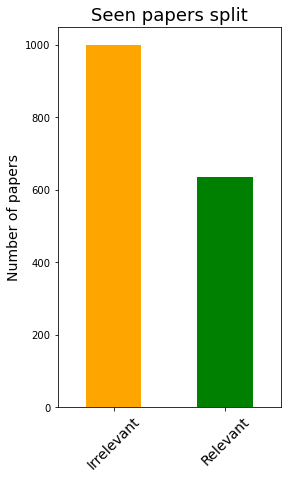

In [55]:
ax = df['Relevant'].value_counts().plot.bar(figsize = (4,7), color=['orange', 'green'])
ax.set_xticklabels(['Irrelevant','Relevant'], rotation = 45, fontsize=14)
ax.set_ylabel("Number of papers", fontsize=14)
ax.set_title('Seen papers split',fontsize=18)
plt.savefig('seen_relevant.png', dpi='figure',
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

## Split the data into train & test sets:

In [5]:
from sklearn.model_selection import train_test_split

X = df['Abstract']
y = df['Relevant']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Build pipelines to vectorize the data, then train and fit a model
Now that we have sets to train and test, we'll develop a selection of pipelines, each with a different model.

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, OneClassSVM


# Naïve Bayes:
text_clf_nb = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB()),
])

# Linear SVC:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])


#SVC
text_clf_nlsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', SVC(kernel='rbf',class_weight='balanced',probability=True, random_state= 2020)),
])

# Random forset: 
text_clf_forest= Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', RandomForestClassifier(n_estimators =400,criterion="entropy",random_state =0))
])    

# Neural net

text_clf_neuralnet= Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MLPClassifier(solver='lbfgs', alpha=0.1, hidden_layer_sizes=(10), random_state=0))
])

## Feed the training data through the first pipeline
We'll run naïve Bayes first

In [10]:
text_clf_nb.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

## Run predictions and analyze the results (naïve Bayes)

In [11]:
# Form a prediction set
predictions = text_clf_nb.predict(X_test)

In [12]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[333   4]
 [181  22]]


In [13]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.65      0.99      0.78       337
           1       0.85      0.11      0.19       203

    accuracy                           0.66       540
   macro avg       0.75      0.55      0.49       540
weighted avg       0.72      0.66      0.56       540



In [14]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.6574074074074074


## Feed the training data through the second pipeline
Next we'll run Linear SVC

In [15]:
text_clf_lsvc.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

## Run predictions and analyze the results (Linear SVC)

In [16]:
# Form a prediction set
predictions = text_clf_lsvc.predict(X_test)

In [17]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[290  47]
 [ 54 149]]


In [18]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       337
           1       0.76      0.73      0.75       203

    accuracy                           0.81       540
   macro avg       0.80      0.80      0.80       540
weighted avg       0.81      0.81      0.81       540



In [19]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.812962962962963


## Feed the training data through the third pipeline (Random forest)


In [20]:
text_clf_forest.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 RandomForestClassifier(criterion='entropy', n_estimators=400,
                                        random_state=0))])

In [21]:
# Form a prediction set
predictions = text_clf_forest.predict(X_test)

In [22]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[303  34]
 [ 77 126]]


In [23]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       337
           1       0.79      0.62      0.69       203

    accuracy                           0.79       540
   macro avg       0.79      0.76      0.77       540
weighted avg       0.79      0.79      0.79       540



In [24]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.7944444444444444


## Feed the training data through the fourth pipeline (Neural net)

In [25]:
text_clf_neuralnet.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 MLPClassifier(alpha=0.1, hidden_layer_sizes=10, random_state=0,
                               solver='lbfgs'))])

In [26]:
# Form a prediction set
predictions = text_clf_neuralnet.predict(X_test)

In [27]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[280  57]
 [ 50 153]]


In [28]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       337
           1       0.73      0.75      0.74       203

    accuracy                           0.80       540
   macro avg       0.79      0.79      0.79       540
weighted avg       0.80      0.80      0.80       540



In [29]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.8018518518518518


# Feed the training data through the fifth pipeline (SVC)

In [30]:
text_clf_nlsvc.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 SVC(class_weight='balanced', probability=True,
                     random_state=2020))])

In [31]:
# Form a prediction set
predictions = text_clf_nlsvc.predict(X_test)

In [32]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[293  44]
 [ 61 142]]


In [33]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       337
           1       0.76      0.70      0.73       203

    accuracy                           0.81       540
   macro avg       0.80      0.78      0.79       540
weighted avg       0.80      0.81      0.80       540



In [33]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.8055555555555556


### Cross-validation with k-folds 
This method has some advantages over train-test-split as it samples a different set of data for testing and training each time (or for each fold). We have used a script from Graham Harrison used at Kaggle competitions. Here the extensive explanation: https://towardsdatascience.com/how-to-plot-a-confusion-matrix-from-a-k-fold-cross-validation-b607317e9874. 

* We create a new model using any of the classifyer above
* We apply the cross validation to the model 
* We calculate the confusion matrix
* We visualise the confusion matrix

In [34]:
#Applying k-fold with any of the models
#Iterates over each of the 5 folds
#For each fold, fits the model to the 4/5 ths of data reserved for training
#Evaluates the performance of the model against the 1/5 th of the data reserved for testing

from sklearn.model_selection import KFold, cross_val_score
X = df['Abstract']
y = df['Relevant']

# Random forset: 
#text_clf_forest_k= Pipeline([('tfidf', TfidfVectorizer()),
#                   ('clf', RandomForestClassifier(n_estimators =400,criterion="entropy",random_state =44))
#])

#Neutral net
#text_clf_neuralnet_k= Pipeline([('tfidf', TfidfVectorizer()),
#                     ('clf', MLPClassifier(solver='lbfgs', alpha=0.01, hidden_layer_sizes=(10,), random_state=0))
#])

# SVC:
text_clf_nlsvc_k = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', SVC(kernel='rbf',class_weight='balanced',probability=True, random_state= 2020)),
])



# Linear SVC:
#text_clf_lsvc_k = Pipeline([('tfidf', TfidfVectorizer()),
#                    ('clf', LinearSVC()),
#])



kfold = KFold(n_splits=4, random_state=44, shuffle=True)

cv_results = cross_val_score(text_clf_nlsvc_k, X, y, cv=kfold, scoring='accuracy', verbose=10)

print(cv_results.mean(), cv_results.std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.790) total time=  10.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s remaining:    0.0s


[CV] END ................................ score: (test=0.863) total time=  10.5s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.8s remaining:    0.0s


[CV] END ................................ score: (test=0.858) total time=  10.1s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.9s remaining:    0.0s


[CV] END ................................ score: (test=0.839) total time=  10.0s
0.8374083129584352 0.029006871681429514


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   40.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   40.9s finished


In [35]:
from sklearn.metrics import confusion_matrix

In [36]:
def cross_val_predict(model, kfold : KFold, X : np.array, y : np.array) -> Tuple[np.array, np.array, np.array]:

    model_ = cp.deepcopy(model)
    
    no_classes = len(np.unique(y))
    
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes]) 

    for train_ndx, test_ndx in kfold.split(X):

        train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]

        actual_classes = np.append(actual_classes, test_y)

        model_.fit(train_X, train_y)
        predicted_classes = np.append(predicted_classes, model_.predict(test_X))

        try:
            predicted_proba = np.append(predicted_proba, model_.predict_proba(test_X), axis=0)
        except:
            predicted_proba = np.append(predicted_proba, np.zeros((len(test_X), no_classes), dtype=float), axis=0)

    return actual_classes, predicted_classes, predicted_proba

In [37]:
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):

    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    
    plt.figure(figsize=(12.8,6))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

    plt.show()

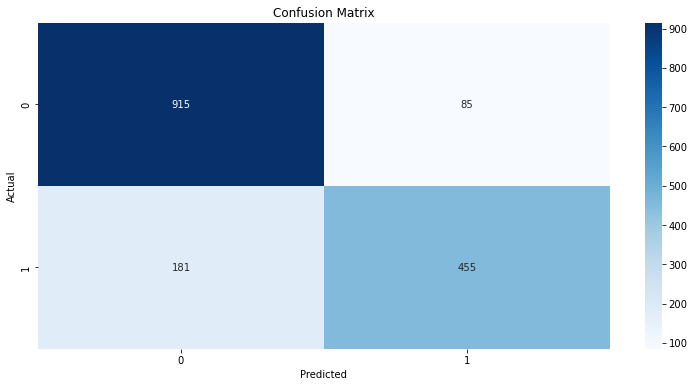

In [38]:
actual_classes, predicted_classes, predicted_proba = cross_val_predict(text_clf_nlsvc_k, kfold, X.to_numpy(), y.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, [0, 1])

What do we conclude from the confusion matrix and can we improve?

The k-fold improve performance.

### For the k-fold model you need to fit to the whole data set

In [39]:
text_clf_nlsvc_k.fit(X,y)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 SVC(class_weight='balanced', probability=True,
                     random_state=2020))])

In [40]:
y_pred_seen = text_clf_nlsvc_k.predict_proba(X)

### Next, feed new data to the model's `predict()` method 

In [41]:
mybrandnewabstract = "Low-carbon lifestyles are key to climate change mitigation, biodiversity conservation, and keeping the Earth in a safe operating space. Understanding the global feasibility and drivers of low-carbon lifestyles requires large scale data covering various countries, demographic and socioeconomic groups. In this study, we use the audience segmentation data from Facebook‚Äôs advertising platform to analyse the extent and drivers of interest in sustainable lifestyles, plant-based diets in particular, at a global level. We show that formal education level is the most important factor affecting vegetarianism interest, and it creates a sharper difference in low-income countries. Gender is a strong distinguishing factor, followed by national gross domestic product per capita and age. These findings enable upscaling local empirical studies to a global level with confidence for integrated assessments of low-carbon lifestyles. Future studies can expand this analysis of social media audience data to other consumption areas, such as household energy demand, and can also contribute to quantifying the psychosocial drivers of low-carbon lifestyles, such as personal and social norms."

In [42]:
print(text_clf_nlsvc_k.predict([mybrandnewabstract]))  # be sure to put "mybrandnewabstract" inside square brackets

[0]


## Predict labels for the unseen dataset using the best performing model

In [43]:
### TODO Add your file path ###
file_path = '../Data/'
#File that was extracted from the big database having only labelled data. Relevant = 1 means relevant.
file_name2 = 'unseen.xlsx'
df_unseen = pd.read_excel(file_path + file_name2)

df_unseen.head()

,DOI,Title,Abstract,Source title,PubYear,Authors,Times cited,processed_text,topic_0,topic_1,topic_2,topic_3,topic_4,Topic,Topic Label
0,10.1016/j.trd.2015.07.004,Objective correlates and determinants of bicyc...,Objective Bicycle use for commuting is being e...,Transportation Research Part D Transport and E...,2015.0,"Cole-Hunter, T.; Donaire-Gonzalez, D.; Curto, ...",69,"['object', 'bicycl', 'use', 'commut', 'encoura...",0.008755,0.012644,0.006103,0.011916,0.005234,1,Adaptation/Livelihoods/Agriculture
1,10.1093/poq/nfaa002,ADDRESSING GLOBAL WARMING DENIALISM THE EFFICA...,Despite the scientific consensus concerning th...,PUBLIC OPINION QUARTERLY,2020.0,"Rotman, Jeff D.; Weber, T. J.; Perkins, Andrew W.",2,"['despit', 'scientif', 'consensus', 'concern',...",0.028418,0.006693,0.017148,0.005094,0.014798,0,Sustainable development
2,10.1787/22185514-en,"One Step Forward, Two Steps Backwards? Youth A...",Young people across OECD countries enjoy unpre...,OECD Public Governance Reviews,2020.0,OECD,0,"['young', 'peopl', 'oecd', 'countri', 'enjoy',...",0.030466,0.000000,0.000000,0.010823,0.002424,0,Sustainable development
3,10.7832/45-2-181,"True disciples, nature and leiturgia: Preserva...",God created man in his image ( imago Dei ) and...,Missionalia,2017.0,"Marumo, Phemelo Olifile; Van der Merwe, Sarel",0,"['god', 'creat', 'man', 'imag', 'imago', 'dei'...",0.017874,0.000000,0.001276,0.010707,0.000000,0,Sustainable development
4,10.4278/0890-1171-19.2.103,"Team awareness, problem drinking, and drinking...",Purpose. (1) To determine the effectiveness of...,AMERICAN JOURNAL OF HEALTH PROMOTION,2004.0,"Bennett, JB; Patterson, CR; Reynolds, GS; Wiit...",41,"['purpos', 'determin', 'effect', 'classroom', ...",0.004793,0.008533,0.023950,0.038815,0.002208,3,HealthMedical


In [44]:
topic_results_3 = text_clf_nlsvc_k.predict(df_unseen['Abstract'])

In [45]:
y_pred = text_clf_nlsvc_k.predict_proba(df_unseen['Abstract'])

In [46]:
df_unseen['Relevant'] = topic_results_3

In [47]:
df_unseen['Probability'] = y_pred[:,1]

In [48]:
df_unseen['Relevant'].value_counts()

0    9989
1    4805
Name: Relevant, dtype: int64

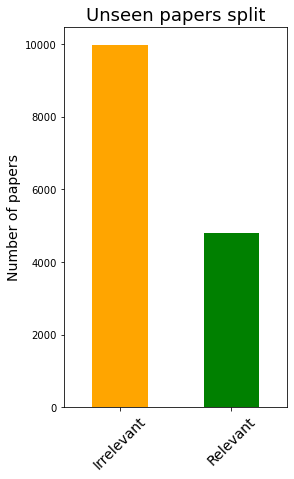

In [57]:
ax = df_unseen['Relevant'].value_counts().plot.bar(figsize = (4,7), color=['orange', 'green'])
ax.set_xticklabels(['Irrelevant','Relevant'], rotation = 45, fontsize=14)
ax.set_ylabel("Number of papers", fontsize=14)
ax.set_title('Unseen papers split',fontsize=18)
plt.savefig('../Figures/unseen_relevant.png', dpi='figure',
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [58]:
df_final = df_unseen[df_unseen['Relevant'] == 1]

In [59]:
df['Probability'] = y_pred_seen[:,1]

In [60]:
df_final_seen = df[df['Relevant'] == 1]

In [63]:
npr1 = df_final_seen[['DOI','Title','Abstract', 'Source title','PubYear','Authors',
             'Times cited','Relevant','Probability']]

In [64]:
npr2 = df_final[['DOI','Title','Abstract', 'Source title','PubYear','Authors',
             'Times cited','Relevant','Probability']]

In [67]:
npr2['PubYear'] = npr2['PubYear'].astype(int)

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_63639/3280730843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  npr2['PubYear'] = npr2['PubYear'].astype(int)


## Merge seen and unseen files for the relevant papers

In [69]:
npr = pd.concat([npr1, npr2])

In [71]:
npr.reset_index(inplace = True)

In [72]:
npr['Relevant'].value_counts()

1    5441
Name: Relevant, dtype: int64

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [74]:
import spacy
nlp = spacy.load("en_core_web_lg")

2022-12-01 21:01:31.783527: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [75]:
nlp.Defaults.stop_words |= {"climate","change","education", "climatic","changes","climat", "changing", "chang",
                           "educ", "educational", "educative", "teach", "teaching","global", "warming", "die", 
                           "und", "das", "pro", "auf",'11','ve'}

In [76]:
#Use the spacy lemmatizer to get the best result so far
npr['abstract_lemmatized'] = npr['Abstract'].apply(lambda row: " ".join([w.lemma_ for w in nlp(row)]))

In [77]:
stop_words_2 = nlp.Defaults.stop_words

In [78]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stop_words_2)

In [79]:
dtm = tfidf.fit_transform(npr['abstract_lemmatized'])

/Users/vmuccion/opt/anaconda3/envs/ClimateEducation/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll'] not in stop_words.
  warnings.warn(


In [80]:
tfidf_weights = [(word, dtm.getcol(idx).sum()) for word, idx in tfidf.vocabulary_.items()]

In [81]:
feature_names = tfidf.get_feature_names_out()

In [82]:
from wordcloud import WordCloud
w = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=200).fit_words(dict(tfidf_weights))

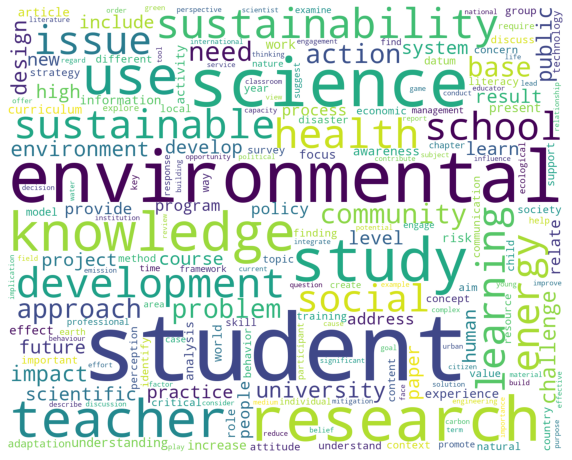

In [84]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,15))
plt.imshow(w)
plt.axis('off')
plt.savefig('../Figures/Climate_Education.png', dpi='figure',facecolor='auto', edgecolor='auto',pad_inches=0.1)

In [85]:
occ = np.asarray(dtm.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': tfidf.get_feature_names_out(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20)

,term,occurrences
10237,student,232.733123
3997,environmental,195.087244
9523,science,171.007098
9157,research,140.673424
10245,study,133.815100
6216,knowledge,126.646005
11254,use,124.569506
10531,teacher,120.180239
10404,sustainability,116.402136
3208,development,115.638149


In [86]:
weights = np.asarray(dtm.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tfidf.get_feature_names_out(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

,term,weight
10237,student,0.042774
3997,environmental,0.035855
9523,science,0.031429
9157,research,0.025854
10245,study,0.024594
6216,knowledge,0.023276
11254,use,0.022895
10531,teacher,0.022088
10404,sustainability,0.021394
3208,development,0.021253


In [87]:
from sklearn.decomposition import NMF

In [88]:
nmf_model = NMF(n_components=4,random_state=42)

In [89]:
nmf_model.fit(dtm)

/Users/vmuccion/opt/anaconda3/envs/ClimateEducation/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(n_components=4, random_state=42)

In [90]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 20 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 20 WORDS FOR TOPIC #0
['adaptation', 'knowledge', 'environment', 'paper', 'need', 'approach', 'challenge', 'action', 'social', 'research', 'community', 'development', 'sustainable', 'sustainability', 'environmental']


THE TOP 20 WORDS FOR TOPIC #1
['curriculum', 'result', 'research', 'understanding', 'learn', 'knowledge', 'scientific', 'course', 'use', 'learning', 'study', 'school', 'teacher', 'science', 'student']


THE TOP 20 WORDS FOR TOPIC #2


/Users/vmuccion/opt/anaconda3/envs/ClimateEducation/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['address', 'disease', 'training', 'profession', 'environmental', 'impact', 'human', 'healthcare', 'care', 'medical', 'nurse', 'professional', 'public', 'nursing', 'health']


THE TOP 20 WORDS FOR TOPIC #3
['industry', 'use', 'green', 'efficiency', 'source', 'fossil', 'consumption', 'building', 'carbon', 'fuel', 'emission', 'sustainable', 'technology', 'renewable', 'energy']




In [91]:
topic_df3 = pd.DataFrame(
    nmf_model.transform(dtm), 
    columns=["topic_{}".format(i) for i in range(4)]
).astype(float)
topic_df3.index = npr.index
npr = pd.concat([npr, topic_df3], axis=1)

In [92]:
topic_results_4 = nmf_model.transform(dtm)

In [93]:
topic_results_4

array([[0.00000000e+00, 5.67655425e-02, 2.59103385e-01, 0.00000000e+00],
       [3.26400805e-02, 4.95269870e-02, 1.75154857e-02, 1.04864199e-02],
       [3.05947099e-02, 4.33829400e-02, 1.60280553e-04, 6.28414932e-02],
       ...,
       [2.36219239e-02, 5.65837491e-02, 2.61669664e-04, 2.36401018e-03],
       [3.93848555e-02, 5.36917773e-03, 0.00000000e+00, 0.00000000e+00],
       [5.55809954e-02, 0.00000000e+00, 1.50553708e-01, 0.00000000e+00]])

In [94]:
from sklearn.manifold import TSNE

tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=50, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(topic_results_4)

/Users/vmuccion/opt/anaconda3/envs/ClimateEducation/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5441 samples in 0.003s...
[t-SNE] Computed neighbors for 5441 samples in 0.242s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5441
[t-SNE] Computed conditional probabilities for sample 2000 / 5441
[t-SNE] Computed conditional probabilities for sample 3000 / 5441
[t-SNE] Computed conditional probabilities for sample 4000 / 5441
[t-SNE] Computed conditional probabilities for sample 5000 / 5441
[t-SNE] Computed conditional probabilities for sample 5441 / 5441
[t-SNE] Mean sigma: 0.004036
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.234718
[t-SNE] KL divergence after 2000 iterations: 0.918563


In [95]:
tsne_lsa_vectors = pd.DataFrame(tsne_lsa_vectors,columns=['x','y'])
tsne_lsa_vectors['hue'] = topic_results_4.argmax(axis=1)

In [96]:
tsne_lsa_vectors.head()

,x,y,hue
0,4.643126,57.401588,2
1,-11.315334,22.079760,1
2,-1.850329,-43.651093,3
3,-18.843613,12.868874,1
4,11.361151,25.765850,0


In [101]:
topics = ['Adaptation/Sustainability',
          'Learning/Teaching/Research',
          'Health/Medical/Nursing',
          'Energy/Emissions/Mitigation',
         ]

In [200]:
np.where(data['hue']==i)[0][0]

2

In [115]:
legend_list = []
colors = []
for i in range(len(topics)):
    idx = np.where(data['hue']==i)[0][0]
    color = scatter.get_facecolors()[idx]
    colors.append(color)
    legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))

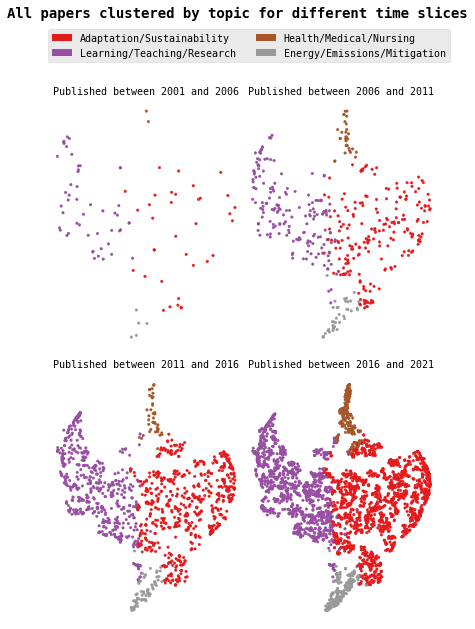

In [178]:
#Figure idea adapted from Isak Falk on Kaggle: 
#https://www.kaggle.com/code/kanabo/nips-papers-visualized-with-nmf-and-t-sne

plt.rc('font',family='monospace')
plt.style.use('ggplot')

fig, axs = plt.subplots(2,2, figsize=(7, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0)

axs = axs.ravel()

count = 0
legend = []
for year, idx in zip([2006,2011,2016,2021], range(6)):
    data = tsne_lsa_vectors[(npr['PubYear']<=year) & (npr['PubYear']>year-5)]
    scatter = axs[idx].scatter(data=data,x='x',y='y',s=6,c=data['hue'],cmap="Set1")
    #axs[idx].set_title('published between {} and {}'.format(year),**{'fontsize':'10'})
    axs[idx].set_title(f"Published between {year-5} and {year}",**{'fontsize':'10'})
    axs[idx].axis('off')

plt.suptitle("All papers clustered by topic for different time slices",**{'fontsize':'14','weight':'bold'})
#plt.figtext(.51,0.95,'unsupervised topic modeling with NMF based on textual content + 2D-embedding with t-SNE:', **{'fontsize':'10','weight':'light'}, ha='center')


fig.legend(legend_list,topics,loc=(0.1,0.9),ncol=2)
plt.subplots_adjust(top=0.85)
#plt.show()
plt.savefig('../Figures/Climate_Education_tse_time.png')

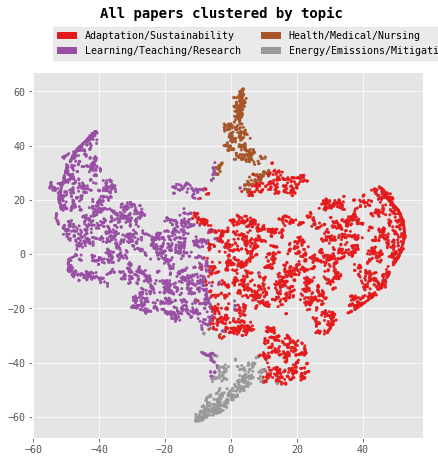

In [183]:
fig, axs = plt.subplots(1,1, figsize=(7, 7), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.001)

data = tsne_lsa_vectors
scatter = plt.scatter(data=data,x='x',y='y',s=6,c=data['hue'],cmap="Set1")
fig.legend(legend_list,topics,loc=(0.12,0.87),ncol=2)
plt.suptitle("All papers clustered by topic",**{'fontsize':'14','weight':'bold'})
plt.subplots_adjust(top=0.85)
#plt.axis('off')
#plt.show()
plt.savefig('../Figures/Climate_Education_tse.png')

In [185]:
npr['Topic'] = topic_results_4.argmax(axis=1)

In [186]:
my_topic_dic = {0: 'Adaptation/Sustainability', 1: 'Learning/Teaching/Research', 
                2:'Health/Medical/Nursing', 3:'Energy/Emissions/Mitigation'}

In [187]:
npr['Topic Label'] = npr['Topic'].map(my_topic_dic)

<AxesSubplot:>

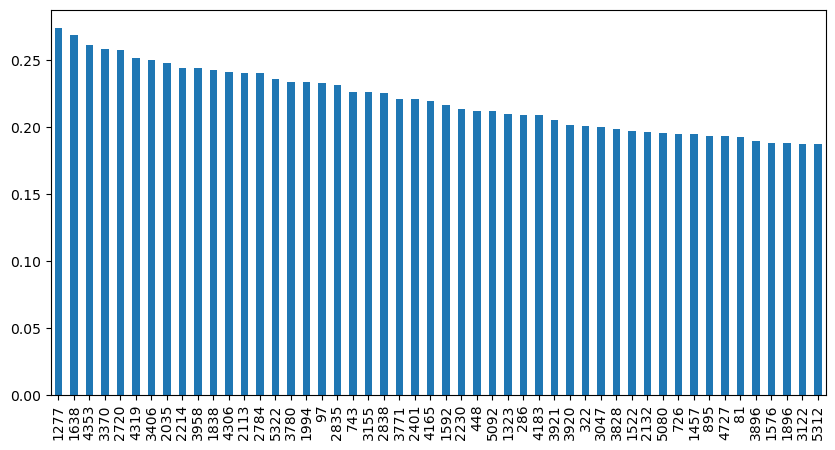

In [189]:
plt.style.use('default')
npr['topic_3'].sort_values(ascending = False).head(50).plot.bar(figsize = (10,5))

Text(0.5, 1.0, 'Paper distribution per topic')

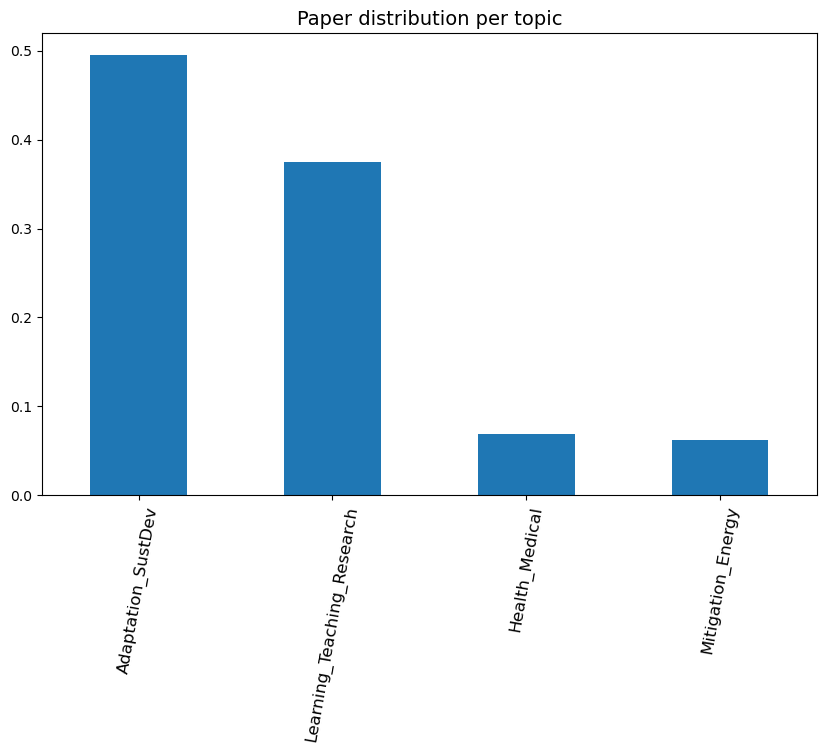

In [190]:
ax = npr["Topic"].value_counts(normalize = True).plot.bar(figsize = (10,6))
ax.set_xticklabels(["Adaptation_SustDev","Learning_Teaching_Research","Health_Medical","Mitigation_Energy"], rotation = 80, fontsize=12)
#ax.set_ylabel("Distribution per topic", fontsize=10)
ax.set_title("Paper distribution per topic", fontsize=14)


<AxesSubplot:>

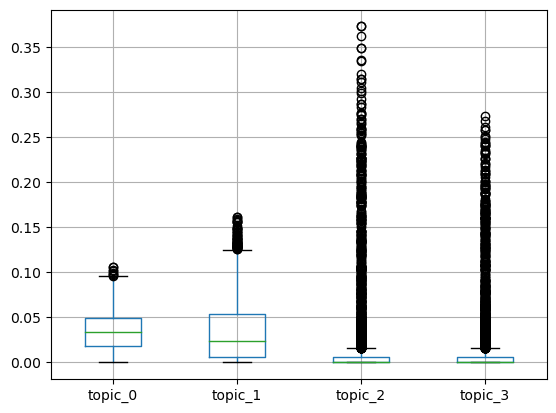

In [191]:
npr.boxplot(column = ['topic_0', 'topic_1', 'topic_2', 'topic_3'])

In [192]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

def corrfunc(x, y, hue = None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

In [193]:
npr_topic = npr[['topic_0','topic_1','topic_2','topic_3']]

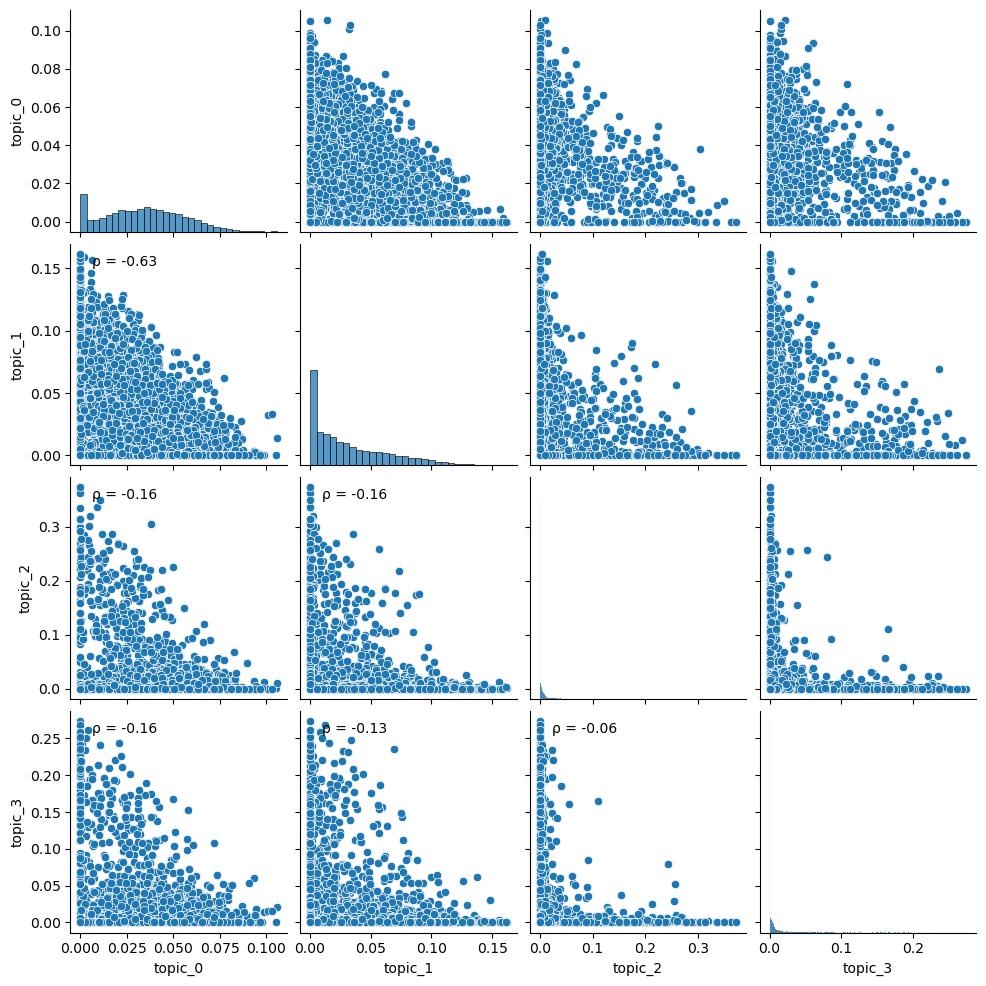

In [198]:
g = sns.pairplot(
    npr_topic,
    x_vars=["topic_0", "topic_1", "topic_2","topic_3"],
    y_vars=["topic_0", "topic_1", "topic_2","topic_3"],
)
g.map_lower(corrfunc)
#plt.show()
plt.savefig('Climate_Education_pairplot.png')

In [ ]:
#import spacy
#nlp = spacy.load("en_core_web_lg")
#from mordecai import Geoparser
#geo = Geoparser()
#geo.geoparse("I took the tube from Oxford Circus to London Bridge, via Bank")

In [609]:
#ax = top_20.plot.bar(x='word', y='frequency')

Something to try will be to make a heatmap with two topic and cross check when both of them exceed a certain threshold, e.g topic university and topic children...

In [ ]:
#threshold = 0.03
#npr_3 = npr[(npr['topic_1'] >= threshold)]
#npr_3.shape

In [195]:
aa= npr_topic[['topic_0','topic_1','topic_2','topic_3']].corr()

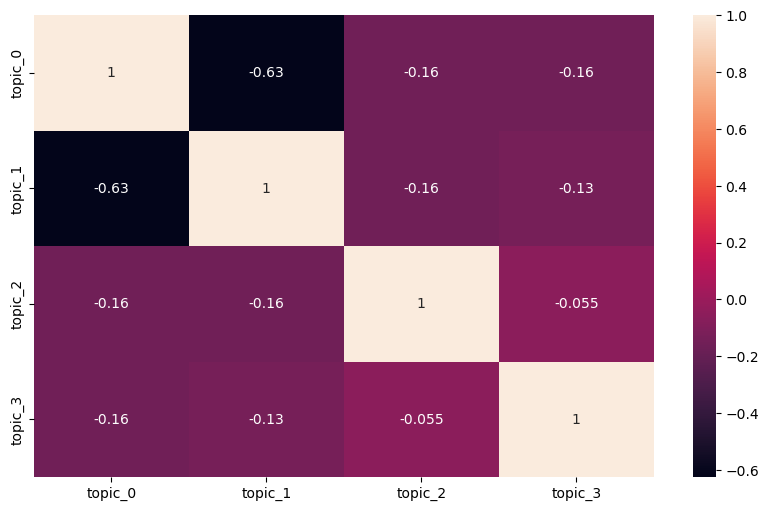

In [197]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(aa, ax=ax, annot=True)
#plt.show()
plt.savefig('Heatmap_topics_all.png')

In [92]:
npr[npr['PubYear'] >=2015].sort_values(by='topic_1', ascending=False).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4095 entries, 4373 to 3431
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                4095 non-null   int64  
 1   DOI                  4095 non-null   object 
 2   Title                4095 non-null   object 
 3   Abstract             4095 non-null   object 
 4   Source title         3785 non-null   object 
 5   PubYear              4095 non-null   int64  
 6   Authors              4061 non-null   object 
 7   Times cited          4095 non-null   int64  
 8   Relevant             4095 non-null   int64  
 9   Probability          4095 non-null   float64
 10  abstract_lemmatized  4095 non-null   object 
 11  topic_0              4095 non-null   float64
 12  topic_1              4095 non-null   float64
 13  topic_2              4095 non-null   float64
 14  topic_3              4095 non-null   float64
 15  Topic                4095 non-null 

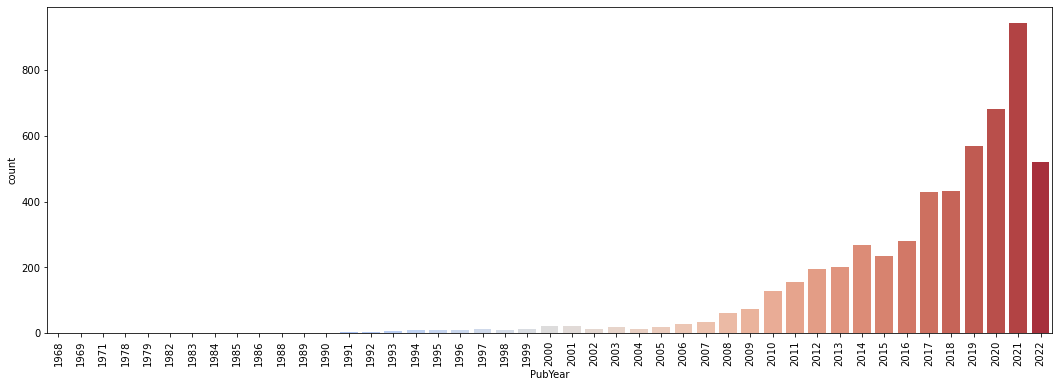

In [93]:
plt.figure(figsize=(18,6))
subgrade_order = sorted(npr['PubYear'].dropna().astype(int).unique())
x1 = npr['PubYear'].dropna().astype(int)
chart = sns.countplot(x=x1,data=npr,order = subgrade_order, palette = 'coolwarm')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
None
#npr['PubYear'].value_counts().plot(kind = 'bar', figsize = (12,6))

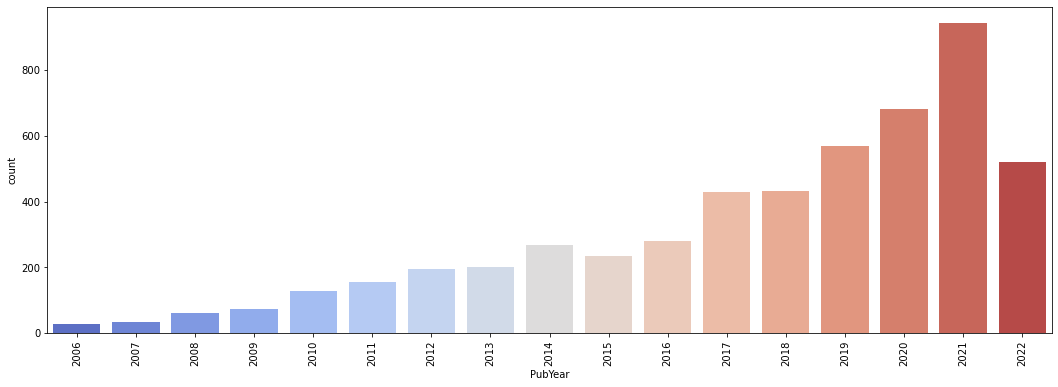

In [667]:
plt.figure(figsize=(18,6))
npr_2006 = npr[npr['PubYear'] >=2006]
subgrade_order = sorted(npr_2006['PubYear'].dropna().astype(int).unique())
x1 = npr_2006['PubYear'].dropna().astype(int)
chart = sns.countplot(x=x1,data=npr_2006,order = subgrade_order, palette = 'coolwarm')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
None

<AxesSubplot:>

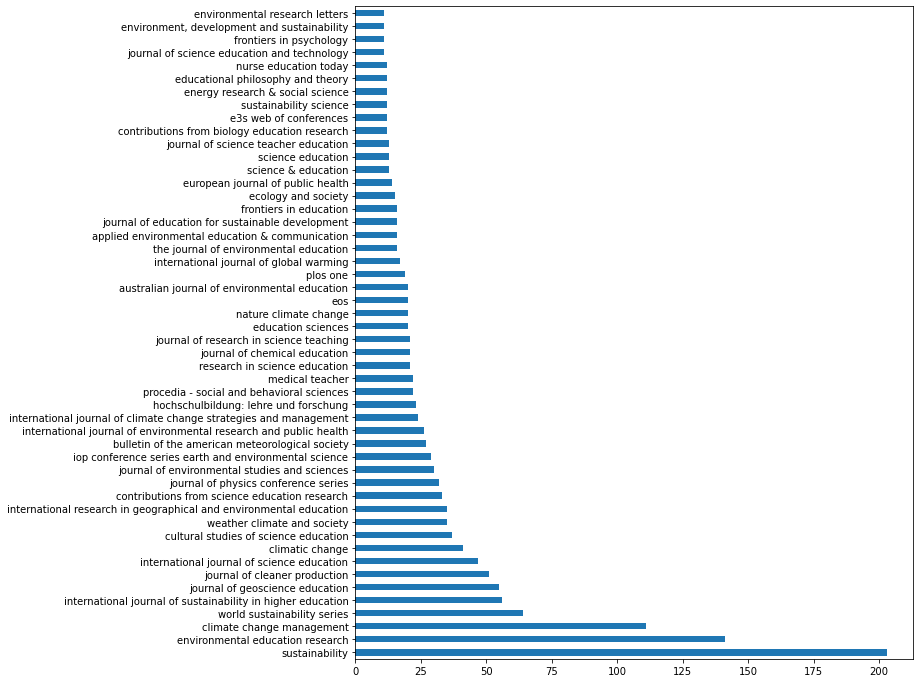

In [698]:
npr_2006['Source title'].str.lower().value_counts().head(50).plot.barh(figsize = (10,12))

In [634]:
npr_2006['Source title'].str.lower().nunique()

1983

In [683]:
npr_2006.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5236 entries, 0 to 5440
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                5236 non-null   int64  
 1   DOI                  5236 non-null   object 
 2   Title                5236 non-null   object 
 3   Abstract             5236 non-null   object 
 4   Source title         4849 non-null   object 
 5   PubYear              5236 non-null   int64  
 6   Authors              5194 non-null   object 
 7   Times cited          5236 non-null   int64  
 8   Relevant             5236 non-null   int64  
 9   Probability          5236 non-null   float64
 10  abstract_lemmatized  5236 non-null   object 
 11  topic_0              5236 non-null   float64
 12  topic_1              5236 non-null   float64
 13  topic_2              5236 non-null   float64
 14  topic_3              5236 non-null   float64
 15  Topic                5236 non-null   i

In [689]:
npr_2006['Source title']=npr_2006['Source title'].str.lower().replace('proceedings of the national academy of sciences of the united states of america','pnas')

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_3916/3312903362.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Top 20 journals')

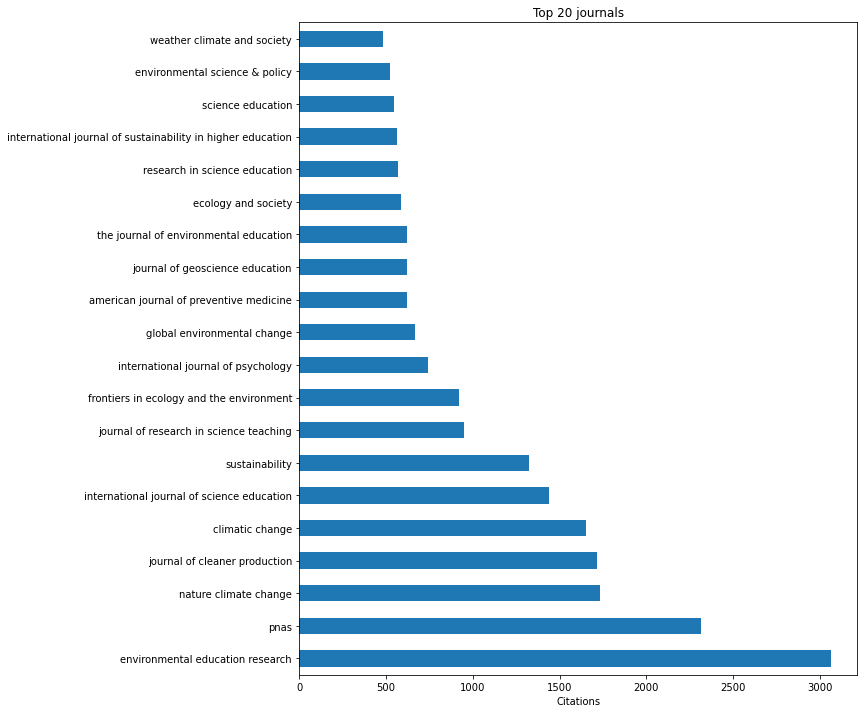

In [695]:
title='Journal citations'
#ylabel='Times cited'
ax = npr_2006.groupby(by=npr_2006['Source title'].str.lower())['Times cited'].sum().sort_values(ascending = False).head(20).plot.barh(figsize = (10,12))
ax.set(ylabel=None)
ax.set(xlabel='Citations')
#ax.set_ylim(10000, 90000)
#ax.set_ylim(10000, 900000)
ax.set_title(label = 'Top 20 journals')

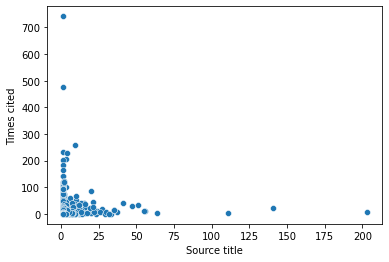

The correlation between average times cited and number of publications in a given journal is 0.03405957528562931


In [709]:
x1 = npr_2006['Source title'].value_counts()
y1 = npr_2006.groupby('Source title')['Times cited'].mean()
sns.scatterplot(data = npr_2006, x=x1, y = y1)
#plt.xlim(0,50)
#plt.ylim(0,500)
plt.show()
print('The correlation between average times cited and number of publications in a given journal is {}'.format(y1.corr(x1)))

In [96]:
aa_2006= npr_2006[['topic_0','topic_1','topic_2','topic_3']].corr()

<AxesSubplot:>

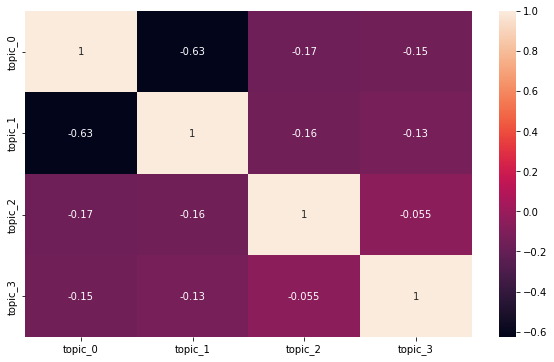

In [97]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(aa_2006, ax=ax, annot=True)

In [98]:
print("Do you want to save the datasets?")
x = input()
if x == 'yes':
    npr_2006.to_csv('/Users/vmuccion/Documents/Projects/ClimateEducation/Data/npr_2006.csv')
    npr_2006.to_excel('/Users/vmuccion/Documents/Projects/ClimateEducation/Data/npr_2006.xlsx',index = False, header=True)
#    npr.to_csv('/Users/vmuccion/Documents/Projects/ClimateEducation/Data/npr.csv')
#    npr.to_excel('/Users/vmuccion/Documents/Projects/ClimateEducation/Data/npr.xlsx',index = False, header=True)
else:
    print('No need to save because answer was: ' + x)

Do you want to save the datasets?
yes


# Geoparsing 
## We perform now some analysis based on countries and continents. 
* First we import the geo parser for geograpghical entity recognition. We use geotext
* We allocate the countries to the whole dataframe
* We then assign country codes and continents to a slice of the dataframe
* We work with this new dataframe to produce maps, spider diagrams etc...

In [99]:
#Trying GeoText. It's not able to recognise when the same countries is talked more than once in the same abstract. 
#This needs to be manually implemented in the dataframe. 
from geotext import GeoText
#places = GeoText("London is a great city")
#places.cities
# "London"
#places.country_mention
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2,country_name_to_country_alpha2,country_name_to_country_alpha3

In [2]:
#Parse countries in the Abstracts
geo_data_country = (npr_2006['Abstract']
#      .replace(r"\bUSA\b", "United States", regex=True)
       .replace((r"\bUSA\b", r"\bUS\b", r"\bU.S.\b") ,"United States",regex=True)      
       .replace((r"\bUK\b", r"\bU.K.\b") ,"United Kingdom",regex=True)                     
       .apply(lambda x: GeoText(x).countries)
)
geo_data_country.info()

NameError: name 'npr_2006' is not defined

In [110]:
geo_data_country = geo_data_country.rename('Countries')

In [362]:
#Add countries as a list to the dataframe column countries
npr_2006['countries'] = geo_data_country

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_3916/521683771.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:>

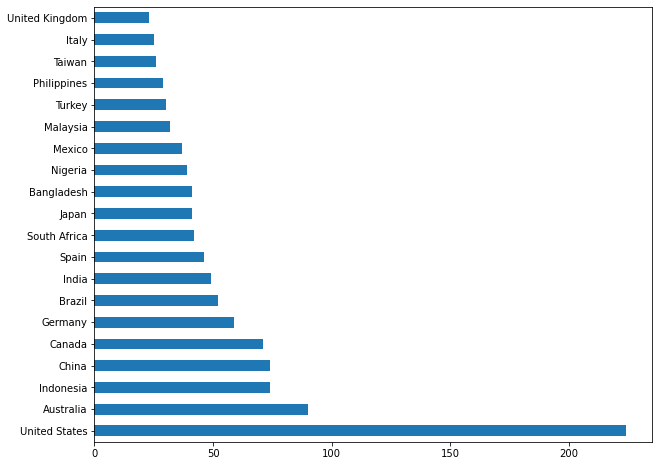

In [364]:
npr_2006['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(ascending=False).head(20).plot.barh(figsize=(10,8)) #autopct='%.2f')

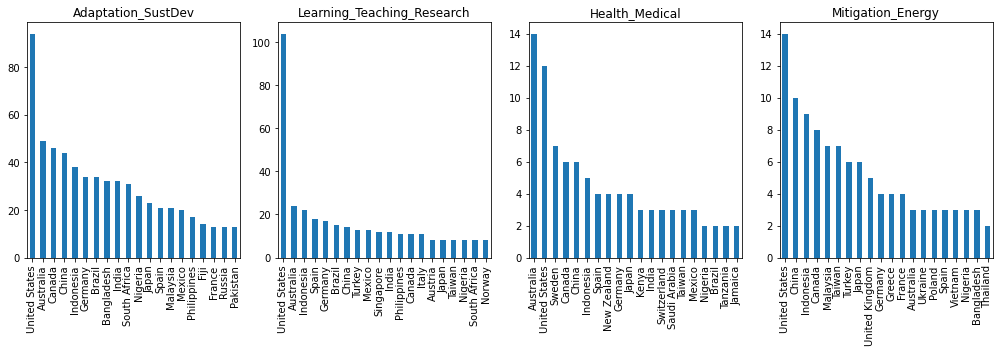

In [551]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize =(14,5))
x0=npr_2006[npr_2006['Topic'] == 0]['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts().head(20) #autopct='%.2f')
x1=npr_2006[npr_2006['Topic'] == 1]['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts().head(20) #autopct='%.2f')
x2=npr_2006[npr_2006['Topic'] == 2]['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts().head(20)#autopct='%.2f')
x3=npr_2006[npr_2006['Topic'] == 3]['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts().head(20) #autopct='%.2f')

#add DataFrames to subplots
x0.plot.bar(ax=axes[0], y = x0.index.sort_values())
axes[0].set_title("Adaptation_SustDev")
x1.plot.bar(ax=axes[1])
axes[1].set_title("Learning_Teaching_Research")
x2.plot.bar(ax=axes[2])
axes[2].set_title("Health_Medical")
x3.plot.bar(ax=axes[3])
axes[3].set_title("Mitigation_Energy")
plt.tight_layout()


In [601]:
#fig, ax = plt.subplots(figsize=(20,10))
#ax = sns.countplot(x = npr_2006['countries'].explode().reset_index().drop_duplicates(keep = "first").dropna()['countries'],
#              data = npr_2006['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(), ax=ax)
#ax.bar_label(ax.containers[0], label_type='edge')
#plt.tight_layout()

In [ ]:
#npr_new.drop_duplicates(keep = "first").head(20)

In [ ]:
#npr_new.groupby(['index', 'countries']).first()

In [175]:
df10 = npr_2006['countries'].explode().reset_index()

In [177]:
#for i, row in df10.iterrows():    
code = []
for p in df10.countries:
    try:
        aa = country_name_to_country_alpha3(p)
        code.append(aa)
    except:
        code.append('')
df10['code'] = code

In [191]:
df10

,index,countries,code
0,0,NaN,
1,1,NaN,
2,2,United Kingdom,GBR
3,2,France,FRA
4,3,Bangladesh,BGD
...,...,...,...
6386,5436,NaN,
6387,5437,NaN,
6388,5438,NaN,
6389,5439,NaN,


In [ ]:
#npr_2006.drop('Country_0', axis = 1, inplace = True)

In [ ]:
#npr_2006['continent'].value_counts(ascending=False).head(20).plot.barh(figsize=(10,8)) #autopct='%.2f')

In [ ]:
#npr_2006['continent'].value_counts(ascending=False)

In [194]:
npr_2006['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(ascending=False).head(20)

United States     224
Australia          90
Indonesia          74
China              74
Canada             71
Germany            59
Brazil             52
India              49
Spain              46
South Africa       42
Japan              41
Bangladesh         41
Nigeria            39
Mexico             37
Malaysia           32
Turkey             30
Philippines        29
Taiwan             26
Italy              25
United Kingdom     23
Name: countries, dtype: int64

In [365]:
df8 = npr_2006['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(ascending=False).rename_axis('countries').to_frame('counts')


In [479]:
npr_2006['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries']

0                  NaN
1                  NaN
2       United Kingdom
3               France
4           Bangladesh
             ...      
6386               NaN
6387               NaN
6388               NaN
6389               NaN
6390               NaN
Name: countries, Length: 5704, dtype: object

In [366]:
df8.reset_index(inplace=True)

In [367]:
df8

,countries,counts
0,United States,224
1,Australia,90
2,Indonesia,74
3,China,74
4,Canada,71
...,...,...
146,Cook Islands,1
147,Suriname,1
148,Venezuela,1
149,French Guiana,1


In [368]:
#for i, row in df10.iterrows():    
code = []
continents = []
for p in df8.countries:
    try:
        aa = country_name_to_country_alpha3(p)
        b1 = country_name_to_country_alpha2(p)
        bb = country_alpha2_to_continent_code(b1)
        code.append(aa)
        continents.append(bb) 
    except:
        code.append('')
        continents.append('')
df8['code'] = code
df8['continents'] = continents

In [369]:
df8.head(50)

,countries,counts,code,continents
0,United States,224,USA,NA
1,Australia,90,AUS,OC
2,Indonesia,74,IDN,AS
3,China,74,CHN,AS
4,Canada,71,CAN,NA
5,Germany,59,DEU,EU
6,Brazil,52,BRA,SA
7,India,49,IND,AS
8,Spain,46,ESP,EU
9,South Africa,42,ZAF,AF


In [370]:
df8[df8['countries'] == 'Antarctica']['code'] = df8[df8['countries'] == 'Antarctica']['code'].apply(lambda x: {x : 'ATA'})

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_3916/1422085705.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [377]:
df8['code'].iloc[45] = 'ATA'

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_3916/2749547634.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [371]:
df8['continents'].iloc[45] = 'AQ'

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_3916/4226145254.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [372]:
df8['code'].iloc[127] = 'PSE'

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_3916/1314114160.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [373]:
df8['continents'].iloc[127] = 'AS'

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_3916/2940112392.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [374]:
df8['code'].iloc[79] = 'XK'

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_3916/3238880784.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [375]:
df8['continents'].iloc[79] = 'EU'

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_3916/3664776895.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [379]:
df8.iloc[0:50,:]

,countries,counts,code,continents
0,United States,224,USA,NA
1,Australia,90,AUS,OC
2,Indonesia,74,IDN,AS
3,China,74,CHN,AS
4,Canada,71,CAN,NA
5,Germany,59,DEU,EU
6,Brazil,52,BRA,SA
7,India,49,IND,AS
8,Spain,46,ESP,EU
9,South Africa,42,ZAF,AF


In [1]:
import plotly.express as px
import plotly.graph_objects as go


fig = go.Figure(data=go.Choropleth(
    locations = df8['code'],
    z = df8['counts'],
    text = df8['countries'],
    colorscale = 'sunsetdark',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '',
    colorbar_title = 'Country count',
))
fig.update_geos(projection_type="natural earth")
fig.show()
#plt.savefig('Map.png')

NameError: name 'df8' is not defined

array([<AxesSubplot:ylabel='counts'>], dtype=object)

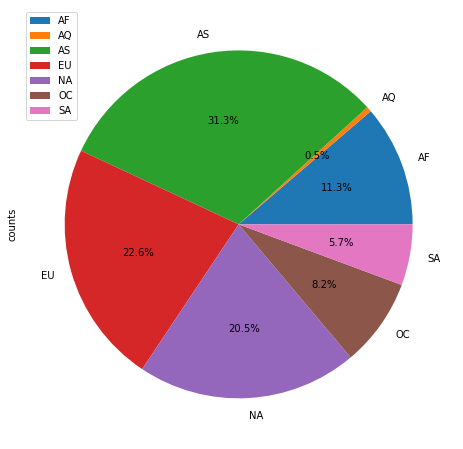

In [381]:
df8.groupby(df8['continents']).sum().plot.pie(subplots=True,figsize=(8,8),legend=True,autopct='%1.1f%%')

In [418]:
df12 = df8.groupby(df8['continents']).sum()

In [419]:
df12.reset_index(inplace=True)

In [420]:
full_name = ['Africa', 'Antarctica', 'Asia', 'Europe', 'N. America', 'S. America', 'Oceania'] 
df12['Continent_Full_Name'] = full_name

In [421]:
df12

,continents,counts,Continent_Full_Name
0,AF,209,Africa
1,AQ,9,Antarctica
2,AS,580,Asia
3,EU,419,Europe
4,NA,380,N. America
5,OC,152,S. America
6,SA,105,Oceania


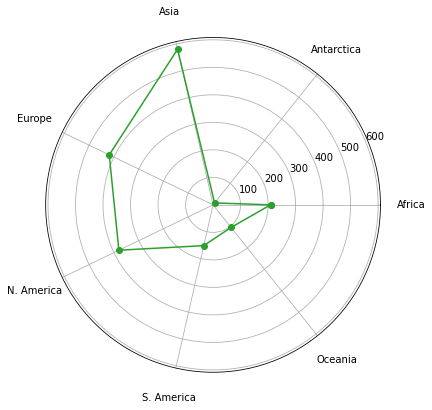

In [436]:
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(111, projection="polar")

# theta has 7 different angles, and the first one repeated
theta = np.arange(len(df12) + 1) / float(len(df12)) * 2 * np.pi
# values has the 7 values from 'counts', with the first element repeated
values = df12['counts'].values
values = np.append(values, values[0])

# draw the polygon and the mark the points for each angle/value combination
l1, = ax.plot(theta, values, color="C2", marker="o", label="counts")
plt.xticks(theta[:-1], df12['Continent_Full_Name'], color='black', size=10)
ax.tick_params(pad=20,labelrotation =0) # to increase the distance of the labels to the plot
# fill the area of the polygon with green and some transparency
#ax.fill(theta, values, 'blue', alpha=0.1)

#plt.legend() # shows the legend, using the label of the line plot (useful when there is more than 1 polygon)
#plt.title("Title")
plt.show()

In [213]:
print("Do you want to save the datasets?")
x = input()
if x == 'yes':
    npr_2006.to_csv('/Users/vmuccion/Documents/Projects/ClimateEducation/Data/npr_2006_countries.csv')
    npr_2006.to_excel('/Users/vmuccion/Documents/Projects/ClimateEducation/Data/npr_2006_countries.xlsx',index = False, header=True)
#    npr.to_csv('/Users/vmuccion/Documents/Projects/ClimateEducation/Data/npr.csv')
#    npr.to_excel('/Users/vmuccion/Documents/Projects/ClimateEducation/Data/npr.xlsx',index = False, header=True)
else:
    print('No need to save because answer was: ' + x)

Do you want to save the datasets?
yes


In [461]:
npr_2006.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5236 entries, 0 to 5440
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                5236 non-null   int64  
 1   DOI                  5236 non-null   object 
 2   Title                5236 non-null   object 
 3   Abstract             5236 non-null   object 
 4   Source title         4849 non-null   object 
 5   PubYear              5236 non-null   int64  
 6   Authors              5194 non-null   object 
 7   Times cited          5236 non-null   int64  
 8   Relevant             5236 non-null   int64  
 9   Probability          5236 non-null   float64
 10  abstract_lemmatized  5236 non-null   object 
 11  topic_0              5236 non-null   float64
 12  topic_1              5236 non-null   float64
 13  topic_2              5236 non-null   float64
 14  topic_3              5236 non-null   float64
 15  Topic                5236 non-null   i

In [537]:
df10 = npr_2006[npr_2006['Topic'] == 1]['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(ascending=False).rename_axis('countries').to_frame('counts')


In [538]:
df10.head(20)

,counts
countries,
United States,104
Australia,24
Indonesia,22
Spain,18
Germany,17
Brazil,15
China,14
Turkey,13
Mexico,13
